# main_test6.py

初始的代码报错，修改一下。


Starting simulation, duration: 100.0 seconds...
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 seconds
Simulation progress: 10.0/100.0 

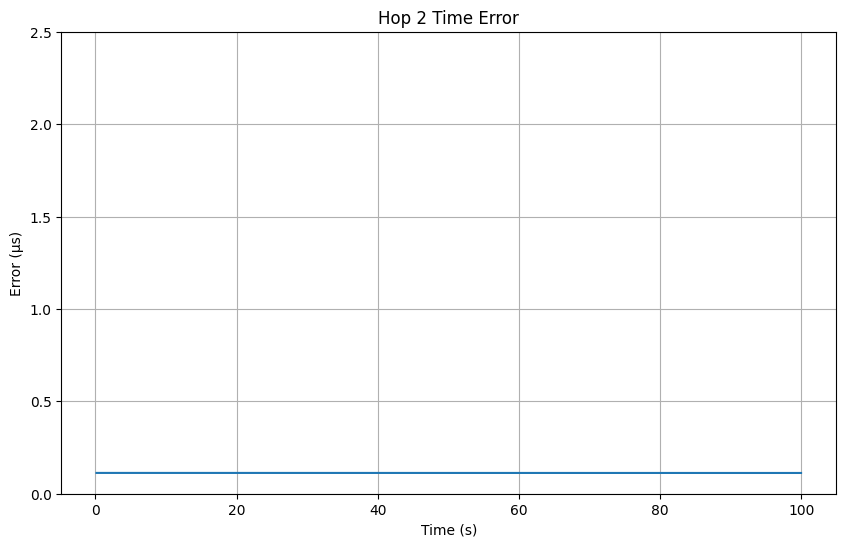

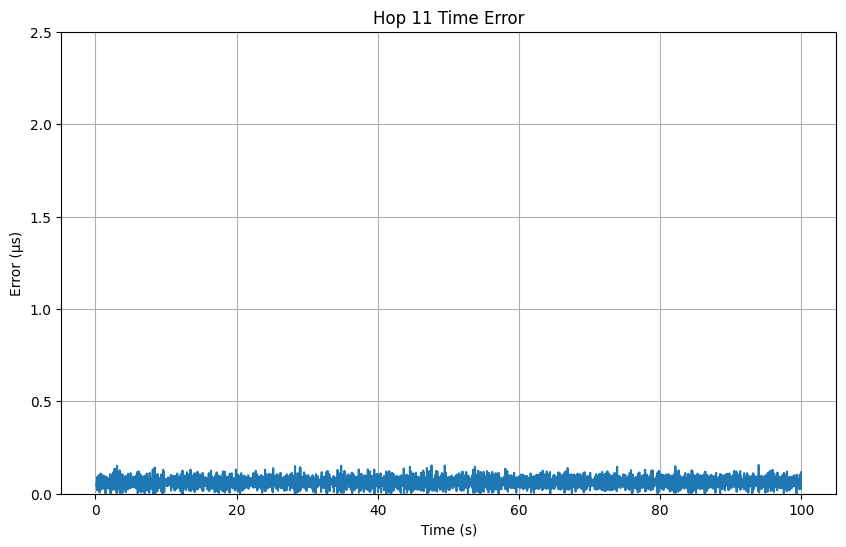

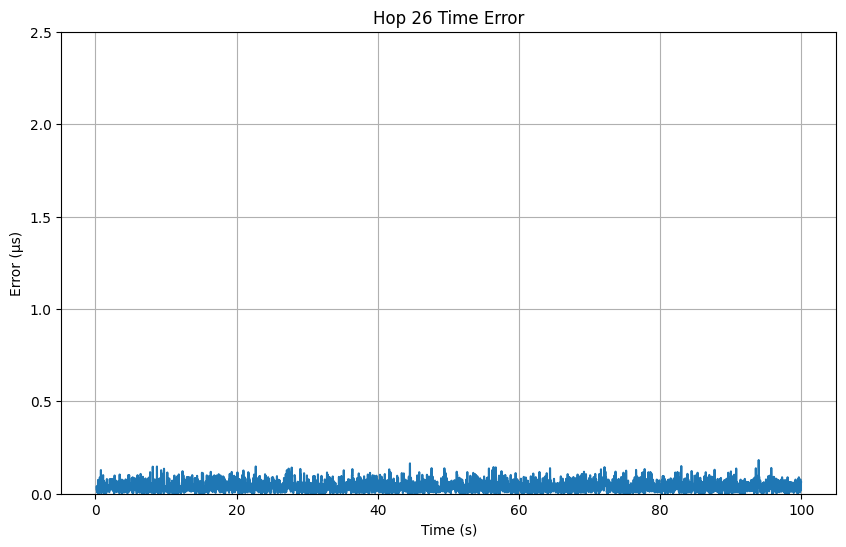

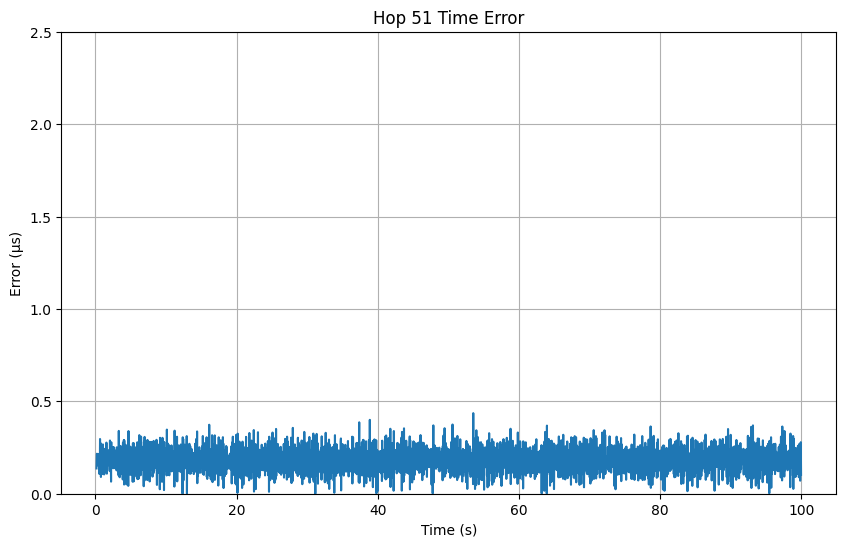

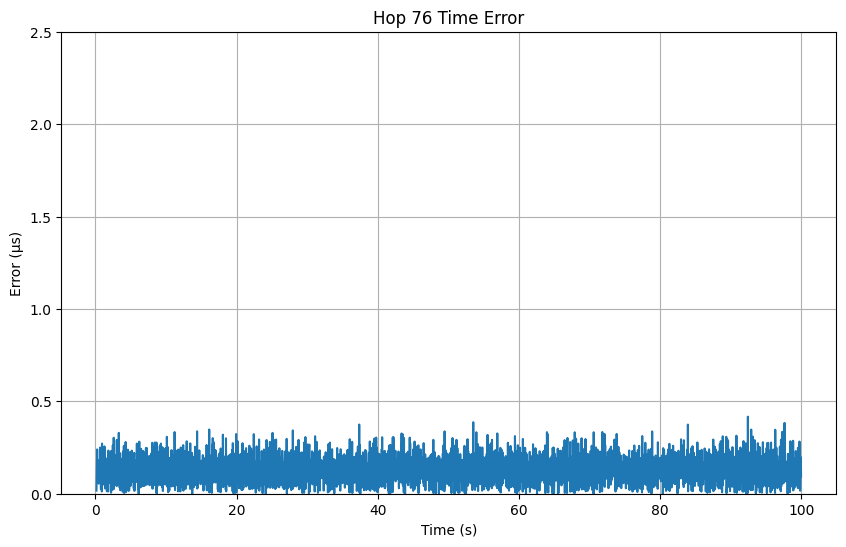

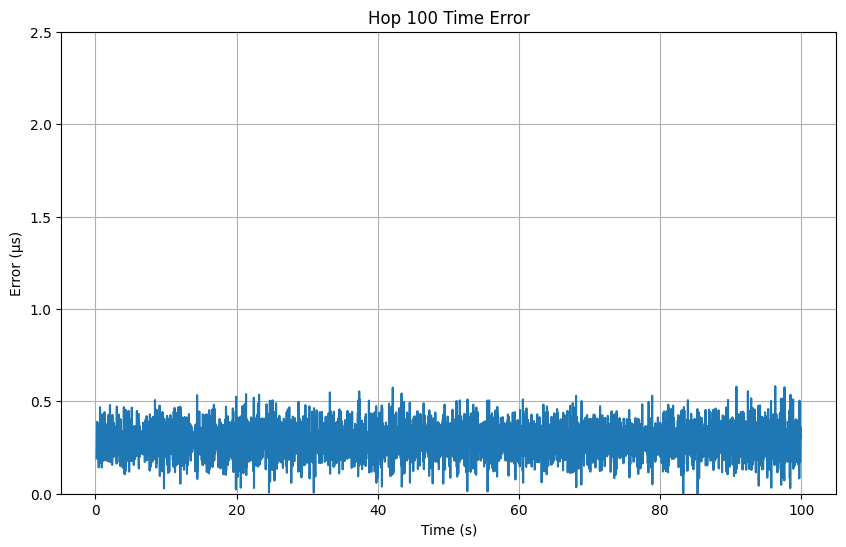

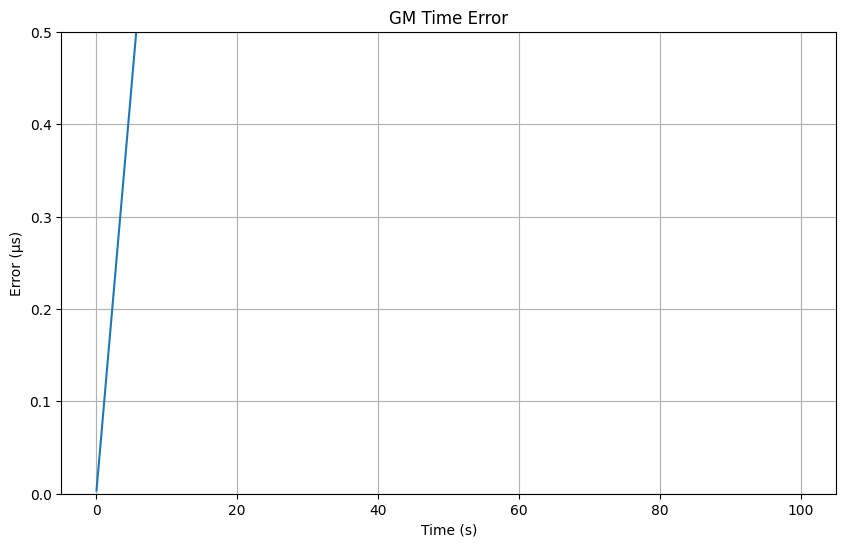

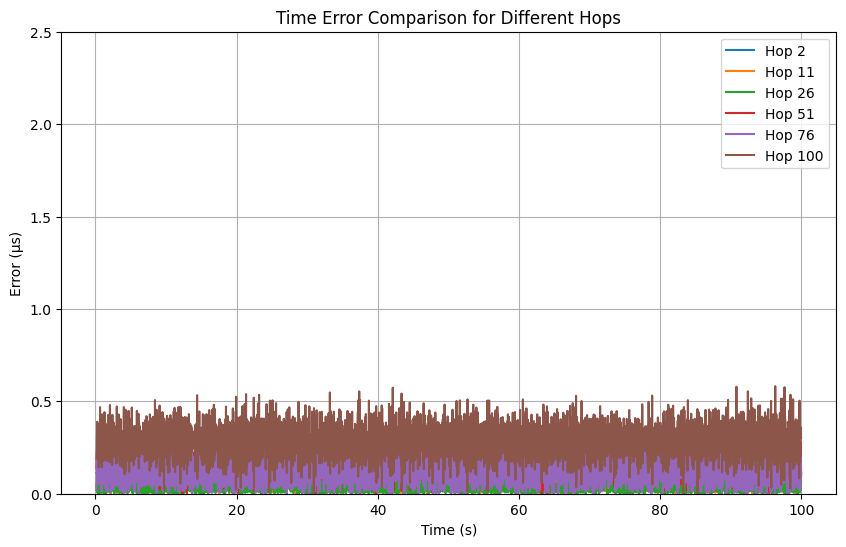

In [7]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

# 常量配置 - 根据论文调整参数
NUM_NODES = 100  # 链式网络中的节点数
SYNC_INTERVAL = 0.03125  # 同步间隔 (31.25 ms)
PHY_JITTER = 8e-9  # PHY抖动范围 (8 ns)
CLOCK_GRANULARITY = 8e-9  # 时钟粒度 (8 ns)
MAX_DRIFT_RATE = 10e-6  # 最大漂移率 (±10 ppm)
SIM_TIME = 100.0  # 仿真总时长 (秒) - 增加以获取更稳定结果
PDELAY_INTERVAL = 1.0  # 传播延迟测量间隔 (1 s)
DRIFT_RATE_CHANGE = 0.1e-6  # 漂移率每秒变化范围调低至 [0, 0.1] ppm/s


class Clock:
    def __init__(self, is_grandmaster=False):
        self.is_grandmaster = is_grandmaster
        # Grandmaster时钟漂移率设为极小的非零值
        if self.is_grandmaster:
            self.drift_rate = np.random.uniform(-0.1e-6, 0.1e-6)
        else:
            # 初始漂移率在 ±10 ppm范围内，符合论文
            self.drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
        self.offset = 0.0
        self.time = 0.0

    def update(self, delta_t):
        # 更符合论文的漂移率变化模型 - 固定频率的小变化
        if not self.is_grandmaster and np.random.random() < 0.01:  # 降低变化概率到1%
            self.drift_rate += np.random.uniform(-DRIFT_RATE_CHANGE, DRIFT_RATE_CHANGE) * delta_t
            self.drift_rate = np.clip(self.drift_rate, -MAX_DRIFT_RATE, MAX_DRIFT_RATE)

        # 更新本地时间（考虑漂移率）
        self.time += delta_t * (1 + self.drift_rate)
        return self.time

    def adjust(self, offset):
        # 调整本地时钟的偏移量（保留漂移率的影响）
        self.offset += offset
        self.time += offset


class Node:
    def __init__(self, node_id, is_grandmaster=False):
        self.id = node_id
        self.is_grandmaster = is_grandmaster
        self.clock = Clock(is_grandmaster=self.is_grandmaster)

        # 根据论文调整物理层参数
        self.residence_time = 0.5e-3 if is_grandmaster else 1e-3  # 驻留时间
        self.propagation_delay = 50e-9  # 传播延迟固定为50ns (论文中的值)

        self.last_sync_time = 0.0
        self.last_pdelay_time = 0.0
        self.asymmetry = 0.0  # 默认无异步
        self.rate_ratio = 1.0
        self.neighbor_rate_ratio = 1.0
        self.sync_errors = []
        self.time_errors = []  # 时间误差记录
        self.gm_time_errors = []  # GM自身时间误差记录

    def receive_sync(self, sync_time, correction_field, network_time):
        # 接收Sync消息时添加抖动和时钟粒度
        actual_receive_time = sync_time + self.propagation_delay + \
                             np.random.uniform(0, PHY_JITTER) + \
                             np.random.uniform(0, CLOCK_GRANULARITY)

        # 计算本地时间与主时钟的偏差
        local_time = self.clock.time
        gm_time = sync_time + correction_field
        error = local_time - gm_time

        # 调整本地时钟
        self.clock.adjust(-error)

        # 记录时间误差
        if self.is_grandmaster:
            self.gm_time_errors.append((network_time, abs(error)))
        else:
            self.time_errors.append((network_time, abs(error)))

        # 添加驻留时间并转发Sync消息
        forward_time = actual_receive_time + self.residence_time
        return forward_time

    def measure_pdelay(self, neighbor):
        # 根据论文实现传播延迟测量
        t1 = self.clock.time
        t2 = neighbor.clock.time + np.random.uniform(0, PHY_JITTER) + np.random.uniform(0, CLOCK_GRANULARITY)
        
        t3 = neighbor.clock.time
        t4 = self.clock.time + np.random.uniform(0, PHY_JITTER) + np.random.uniform(0, CLOCK_GRANULARITY)
        
        # 计算传播延迟
        mean_propagation_delay = ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2)) / 2
        
        # 应用指数平滑
        alpha = 0.1  # 平滑因子
        if hasattr(self, '_propagation_delay_history'):
            self.propagation_delay = (1-alpha) * self._propagation_delay_history + alpha * mean_propagation_delay
            self._propagation_delay_history = self.propagation_delay
        else:
            self.propagation_delay = mean_propagation_delay
            self._propagation_delay_history = mean_propagation_delay


class Network:
    def __init__(self):
        self.nodes = [Node(i, is_grandmaster=(i == 0)) for i in range(NUM_NODES)]
        self.grandmaster = self.nodes[0]
        self.event_queue = []
        self.current_time = 0.0
        self.event_counter = 0
        
        # 设置邻居率比 - 论文中提到为±0.1ppm
        for i in range(1, NUM_NODES):
            prev_node = self.nodes[i-1]
            curr_node = self.nodes[i]
            ideal_rate_ratio = (1 + prev_node.clock.drift_rate) / (1 + curr_node.clock.drift_rate)
            error = np.random.uniform(-0.1e-6, 0.1e-6)  # ±0.1ppm误差
            curr_node.neighbor_rate_ratio = ideal_rate_ratio * (1 + error)

    def schedule_event(self, time, callback, *args):
        heapq.heappush(self.event_queue, (time, self.event_counter, callback, args))
        self.event_counter += 1

    def run_simulation(self):
        # 初始化仿真事件
        self.schedule_event(0.0, self.track_gm_error, self.grandmaster)
        self.schedule_event(0.0, self.send_sync, self.grandmaster)
        for i in range(1, NUM_NODES):
            self.schedule_event(0.0, self.measure_pdelay, self.nodes[i], self.nodes[i - 1])

        # 运行仿真
        print(f"Starting simulation, duration: {SIM_TIME} seconds...")
        while self.event_queue and self.current_time < SIM_TIME:
            time, _, callback, args = heapq.heappop(self.event_queue)

            # 更新所有节点的时钟到当前时间
            delta_t = time - self.current_time
            for node in self.nodes:
                node.clock.update(delta_t)

            self.current_time = time
            callback(*args)
            
            # 显示进度
            if int(self.current_time) % 10 == 0 and int(self.current_time) > 0:
                print(f"Simulation progress: {self.current_time:.1f}/{SIM_TIME} seconds")
        
        print("Simulation completed!")

    def track_gm_error(self, gm_node):
        # 记录GM与理想时间的误差
        ideal_time = self.current_time
        gm_time = gm_node.clock.time
        error = gm_time - ideal_time
        gm_node.gm_time_errors.append((self.current_time, abs(error)))
        self.schedule_event(self.current_time + SYNC_INTERVAL / 4, self.track_gm_error, gm_node)

    def send_sync(self, node):
        sync_time = self.current_time
        correction_field = 0.0
        
        for i in range(1, NUM_NODES):
            # 每个节点接收并更新同步消息
            forward_time = self.nodes[i].receive_sync(sync_time, correction_field, self.current_time)
            
            # 更新校正字段，根据IEEE 802.1AS标准等式(2)
            correction_field += self.nodes[i].propagation_delay
            residence_time = forward_time - (sync_time + self.nodes[i].propagation_delay)
            correction_field += residence_time * self.nodes[i].rate_ratio
            
            # 更新下一跳的同步时间
            sync_time = forward_time

        self.schedule_event(self.current_time + SYNC_INTERVAL, self.send_sync, node)

    def measure_pdelay(self, node, neighbor):
        node.measure_pdelay(neighbor)
        self.schedule_event(self.current_time + PDELAY_INTERVAL, self.measure_pdelay, node, neighbor)

    def plot_individual_errors(self):
        """绘制单独的节点误差图"""
        # 关键节点绘制
        nodes_to_plot = [1, 10, 25, 50, 75, 99]  # 0-based索引
        
        for node_idx in nodes_to_plot:
            node = self.nodes[node_idx]
            if len(node.time_errors) > 5:  # 确保有足够的数据点
                times, errors = zip(*node.time_errors)
                
                # 跳过前5个点以获得稳定数据
                start_idx = 5
                times = times[start_idx:]
                errors = errors[start_idx:]
                
                plt.figure(figsize=(10, 6))
                plt.plot(times, np.array(errors) * 1e6)
                plt.title(f'Hop {node_idx+1} Time Error')
                plt.xlabel('Time (s)')
                plt.ylabel('Error (μs)')
                plt.grid(True)
                plt.ylim(0, 2.5)  # 固定Y轴范围以便比较，与论文保持一致
                plt.show()
        
        # GM误差
        if len(self.grandmaster.gm_time_errors) > 5:
            gm_times, gm_errors = zip(*self.grandmaster.gm_time_errors)
            plt.figure(figsize=(10, 6))
            plt.plot(gm_times[5:], np.array(gm_errors[5:]) * 1e6)
            plt.title('GM Time Error')
            plt.xlabel('Time (s)')
            plt.ylabel('Error (μs)')
            plt.grid(True)
            plt.ylim(0, 0.5)  # GM误差应该更小
            plt.show()
    
    def plot_error_comparison(self):
        """在同一图表中比较所有指定节点的时间误差"""
        nodes_to_plot = [1, 10, 25, 50, 75, 99]  # 0-based索引
        
        plt.figure(figsize=(10, 6))
        
        for node_idx in nodes_to_plot:
            node = self.nodes[node_idx]
            if len(node.time_errors) > 5:
                times, errors = zip(*node.time_errors)
                
                # 使用更多的初始点稳定
                start_idx = 5
                times = times[start_idx:]
                errors = errors[start_idx:]
                
                plt.plot(times, np.array(errors) * 1e6, label=f'Hop {node_idx+1}')
        
        plt.title('Time Error Comparison for Different Hops')
        plt.xlabel('Time (s)')
        plt.ylabel('Error (μs)')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 2.5)  # 固定Y轴范围，与论文保持一致
        plt.show()


if __name__ == "__main__":
    network = Network()
    network.run_simulation()

    # 绘制各个节点的单独图表
    network.plot_individual_errors()
    
    # 绘制所有节点误差的比较图
    network.plot_error_comparison()